# Mount the Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import Packages

In [0]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import matplotlib.ticker as tkr
import seaborn as sns
sns.set()

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix,mean_squared_error
import tensorflow as tf
import random as rn
import os
from tensorflow.keras import optimizers,backend as K
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Activation,BatchNormalization,CuDNNLSTM,Concatenate
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

# Function Definition

In [0]:
def LSTM_data_prep(df,use_mean=True):
  df=df[['Open','High','Low','Close','Volume','SMA_indicator','close_diff_Upper_Bollinger','close_diff_Lower_Bollinger','Bollinger_indicator','true_range','date','weekday','time',
       'close_before_1','close_before_2','close_before_3','close_before_4','close_before_5','close_before_6','close_before_7','close_before_8','close_before_9',
       'median_sentiment_score','mean_sentiment_score','std_sentiment_score','min_sentiment_score','max_sentiment_score']]
  df['std_sentiment_score']=impute_missing_value_sentiment(df['std_sentiment_score'].tolist())
  df['max_sentiment_score']=impute_missing_value_sentiment(df['max_sentiment_score'].tolist())
  df['min_sentiment_score']=impute_missing_value_sentiment(df['min_sentiment_score'].tolist())
  if use_mean:
    df=df.drop(columns=['median_sentiment_score'])
    df['mean_sentiment_score']=impute_missing_value_sentiment(df['mean_sentiment_score'].tolist())
    col=['mean_sentiment_score','std_sentiment_score','max_sentiment_score','min_sentiment_score']
  else:
    df=df.drop(columns=['mean_sentiment_score'])
    df['median_sentiment_score']=impute_missing_value_sentiment(df['median_sentiment_score'].tolist())
    col=['median_sentiment_score','std_sentiment_score','max_sentiment_score','min_sentiment_score']
  
  df=df[~(pd.isnull(df.close_before_9))]
  df=df.reset_index(drop=True)
  return(df)

def impute_missing_value_sentiment(col:list):
  it=range(len(col))
  for i in it:
    if pd.isnull(col[i]):
      if i==1:
        col[i]=col[i+1]
      else:
        col[i]=col[i-1]
  if any(pd.isnull(col)):
    col=impute_missing_value_sentiment(col)
  else:
    return col

def build_sentiment_data(mat,TIME_STEPS,batch_size):
    dim_0 = mat.shape[0] - TIME_STEPS
    mat=mat[:dim_0]

    mat=trim_dataset(mat,batch_size)
    return mat

def build_timeseries(mat, y_col_index,TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

def mape(y_true, y_pred): 
  '''
  Function to calculate MAPE
  '''
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def adjusted_mape(y_true, y_pred): 
  '''
  Function to calculate Adjusted MAPE
  '''
  y_true_after = y_true[1:]
  y_true_before = y_true[:-1]
  y_pred_after = y_pred[1:]
  y_pred_before = y_pred[:-1]

  y_true_label = (pd.Series(y_true_after)-pd.Series(y_true_before)).apply(lambda x: 1 if x>0 else 0)
  y_pred_label = (pd.Series(y_pred_after)-pd.Series(y_pred_before)).apply(lambda x: 1 if x>0 else 0)

  adjustment_constant = np.abs(y_true_label-y_pred_label).apply(lambda x: 2 if x==1 else 1).tolist()
  adjustment_constant.insert(0,1)

  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / (2*y_true)) * adjustment_constant) * 100

def cross_val(df,df_sentiment,TIME_STEPS,BATCH_SIZE,n_fold,input_dropout,hidden_dropout,l2_regularizer,lstm_units_1,lstm_units_2,hidden_units_1,hidden_units_2,optimizer,epochs):
  '''
  TIME_STEPS: how many time steps before which used as predictor
  BATCH_SIZE: how long is a "season" period
  '''
  tscv = TimeSeriesSplit(n_splits=n_fold)
  mape_list=[]
  adj_mape_list=[]
  acc_list = []
  scaler=MinMaxScaler(feature_range=(0,1))
  for train_index, val_index in tscv.split(df):
    print("#Train Samples: ", len(train_index), "#Val Samples: ", len(val_index))
    df_train_raw,df_val_raw=df.loc[train_index,:],df.loc[val_index,:]
    df_sentiment_train,df_sentiment_val=df_sentiment.loc[train_index,:],df_sentiment.loc[val_index,:]

    #Rescaling Historical Data
    df_train_scaled=scaler.fit_transform(df_train_raw)
    df_val_scaled=scaler.transform(df_val_raw)

    #Reformatting Historical Data
    x_t, y_t = build_timeseries(df_train_scaled, 3,TIME_STEPS)
    x_t = trim_dataset(x_t, BATCH_SIZE)
    y_t = trim_dataset(y_t, BATCH_SIZE)
    x_val, y_val = build_timeseries(df_val_scaled, 3,TIME_STEPS)
    x_val = trim_dataset(x_val, BATCH_SIZE)
    y_val = trim_dataset(y_val, BATCH_SIZE)

    #Preparing Sentiment Data
    x_s_t=build_sentiment_data(df_sentiment_train.values,TIME_STEPS,BATCH_SIZE)
    x_s_val=build_sentiment_data(df_sentiment_val.values,TIME_STEPS,BATCH_SIZE)

    #Model Build
    historical_input=Input(batch_input_shape=(None, TIME_STEPS, x_t.shape[2]),name='historical_input')
    x=Dropout(input_dropout)(historical_input)
    x=CuDNNLSTM(lstm_units_1,return_sequences=True,kernel_initializer='random_uniform')(x)
    x=Dropout(hidden_dropout)(x)
    lstm_output=CuDNNLSTM(lstm_units_2,name='lstm_output')(x)
    
    sentiment_input=Input(batch_input_shape=(None,4),name='sentiment_input')
    x = Concatenate(axis=1)([lstm_output, sentiment_input])
    x = Dense(hidden_units_1,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer))(x)
    x = Activation('relu')(x)
    x = Dropout(hidden_dropout)(x)
    x = Dense(hidden_units_2,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer))(x)
    x = Activation('relu')(x)
    x = Dropout(hidden_dropout)(x)
    main_output = Dense(1,name='main_output')(x)

    model = Model(inputs=[historical_input, sentiment_input], outputs=[main_output])

    model.compile(optimizer=optimizer,loss={'main_output': 'mean_squared_error'})

    history=model.fit({'historical_input': x_t, 'sentiment_input': x_s_t}, {'main_output': y_t},
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      epochs=epochs, 
                      verbose=False,
                      validation_data=({'historical_input': trim_dataset(x_val, BATCH_SIZE), 'sentiment_input': x_s_val},{'main_output': trim_dataset(y_val, BATCH_SIZE)}))
  
    y_pred = model.predict({'historical_input': trim_dataset(x_val, BATCH_SIZE), 'sentiment_input': x_s_val},batch_size=BATCH_SIZE)
    y_pred = y_pred.flatten()
    # convert the predicted value to range of real data
    y_pred_org = (y_pred * scaler.data_range_[3]) + scaler.data_min_[3]
    # min_max_scaler.inverse_transform(y_pred)
    y_val_t_org = (y_val * scaler.data_range_[3]) + scaler.data_min_[3]

    MAPE=mape(y_val_t_org, y_pred_org)
    mape_list.append(MAPE)
    print('Val MAPE: ',MAPE)

    adj_MAPE=adjusted_mape(y_val_t_org, y_pred_org)
    adj_mape_list.append(adj_MAPE)
    print('Val Adjusted MAPE: ',adj_MAPE)

    window=7

    y_pred_confusion=y_pred_org.tolist()
    y_pred_after_confusion=y_pred_confusion[window:]
    y_pred_before_confusion=y_pred_confusion[:-window]
    is_bullish_pred=(pd.Series(y_pred_after_confusion)-pd.Series(y_pred_before_confusion)).apply(lambda x: 1 if x>0 else 0)

    y_val_confusion=y_val_t_org.tolist()
    y_val_after_confusion=y_val_confusion[window:]
    y_val_before_confusion=y_val_confusion[:-window]
    is_bullish_val=(pd.Series(y_val_after_confusion)-pd.Series(y_val_before_confusion)).apply(lambda x: 1 if x>0 else 0)

    confusion=confusion_matrix(is_bullish_pred,is_bullish_val)
    acc=(confusion[0][0]+confusion[1][1])/(confusion[0][0]+confusion[0][1]+confusion[1][0]+confusion[1][1])
    acc_list.append(acc)

    print('Val Accuracy: ',acc)

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    print('')
    print('')

    #Plot Prediction Result
    plt.figure()
    plt.plot(y_pred_org)
    plt.plot(y_val_t_org)
    plt.title('Prediction vs Real Stock Price')
    plt.ylabel('Price ($)')
    plt.xlabel('Timesteps')
    plt.legend(['Prediction', 'Real'], loc='upper left')
    plt.show()
    print('')
    print('')

    #Plot Prediction Result - Bahasa Indonesia
    plt.figure()
    plt.plot(y_pred_org)
    plt.plot(y_val_t_org)
    plt.title('Perbandingan Hasil Prediksi dengan Harga Saham Sebenarnya')
    plt.ylabel('Harga ($)')
    plt.xlabel('Waktu')
    plt.legend(['Prediksi', 'Sebenarnya'], loc='upper left')
    plt.show()

  print('10-Fold Accuracy Test Avg Score: {}, Std Score: {}'.format(np.mean(acc_list),np.std(acc_list)))
  print('10-Fold MAPE Test Avg Score: {}, Std Score: {}'.format(np.mean(mape_list),np.std(mape_list)))
  print('10-Fold Adjusted MAPE Test Avg Score: {}, Std Score: {}'.format(np.mean(adj_mape_list),np.std(adj_mape_list)))
  print('Epochs: {}'.format(epochs))
  print('LSTM Nodes 1: {}'.format(lstm_units_1))
  print('LSTM Nodes 2: {}'.format(lstm_units_2))
  print('Input Dropout Rate: {}'.format(input_dropout))
  print('Hidden Dropout Rate: {}'.format(hidden_dropout))
  print('Optimizer: {}'.format(optimizer))
  print('')

def rescaling(df,columns,scale_type='Standard'):
  '''
  Function for Feature Scaling
  '''
  scale_type=scale_type.lower()
  scaled_X=df.drop(columns,1)
  X=df[columns]
  
  if scale_type=='minmax':
    scaler=MinMaxScaler(feature_range=(0,1))
  elif scale_type=='standard':
    scaler=StandardScaler()

  scaled_column=scaler.fit_transform(X)
  scaled_column=pd.DataFrame(scaled_column,columns=columns)
  for column in columns:
    scaled_X[column]=scaled_column[column].tolist()
  return(scaled_X)

# Import Data

In [0]:
link ='https://drive.google.com/open?id=1Zpy6dTBCdZmcWwByQjCM1He8DzSe8Ynr'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df.csv')  
df = pd.read_csv('df.csv')
df=df.drop('Unnamed: 0',1)
df_mean_sentiment=LSTM_data_prep(df,use_mean=True)

df_historical=df_mean_sentiment[[x for x in df_mean_sentiment.columns if x not in ['mean_sentiment_score','std_sentiment_score','min_sentiment_score','max_sentiment_score']]]
df_sentiment=df_mean_sentiment[['mean_sentiment_score','std_sentiment_score','min_sentiment_score','max_sentiment_score']]

1Zpy6dTBCdZmcWwByQjCM1He8DzSe8Ynr


# Hyperparameter Tuning

#Train Samples:  161 #Val Samples:  158
Val MAPE:  1.7331697195589475
Val Adjusted MAPE:  1.3372749473700893
Val Accuracy:  0.7132867132867133


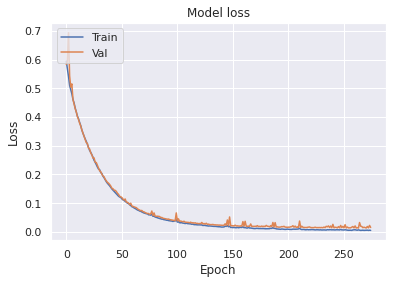

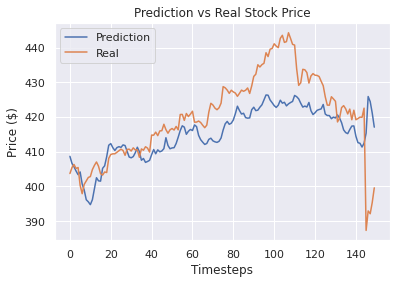

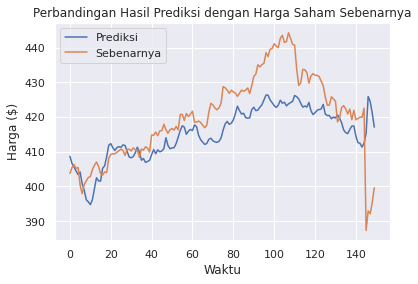

#Train Samples:  319 #Val Samples:  158
Val MAPE:  1.71484596004619
Val Adjusted MAPE:  1.2849539252216107
Val Accuracy:  0.6713286713286714


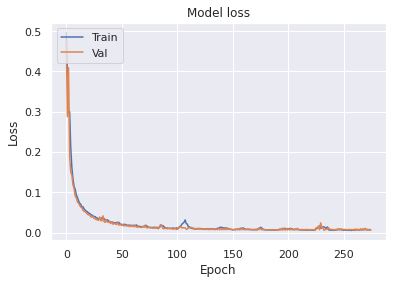

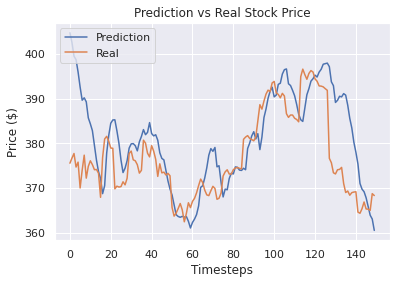

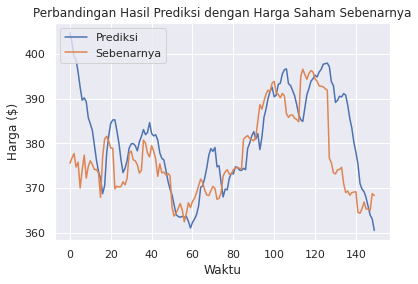

#Train Samples:  477 #Val Samples:  158
Val MAPE:  0.8279548077868876
Val Adjusted MAPE:  0.627567880800425
Val Accuracy:  0.6433566433566433


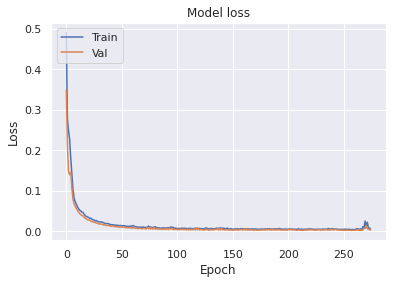

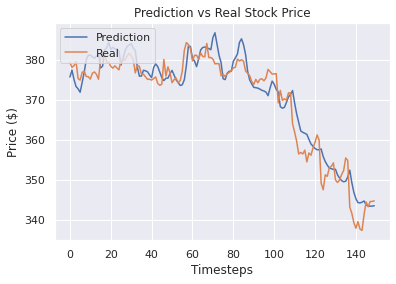

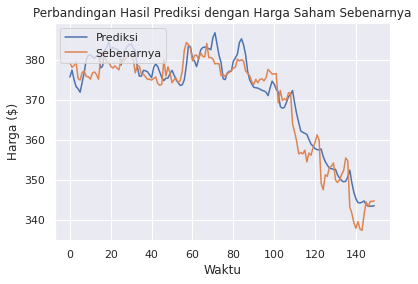

#Train Samples:  635 #Val Samples:  158
Val MAPE:  0.956860773602837
Val Adjusted MAPE:  0.6820065840847054
Val Accuracy:  0.7272727272727273


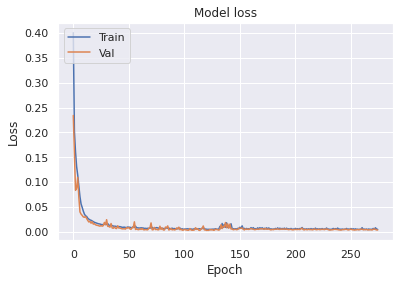

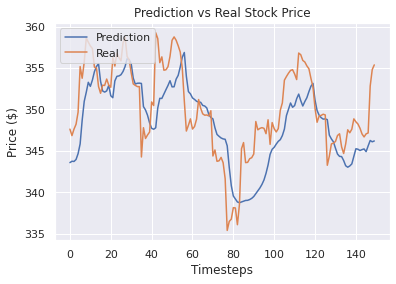

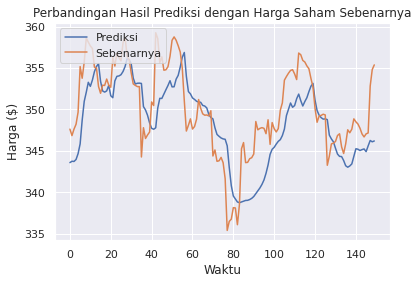

#Train Samples:  793 #Val Samples:  158
Val MAPE:  0.8016387431508306
Val Adjusted MAPE:  0.576378054125235
Val Accuracy:  0.7622377622377622


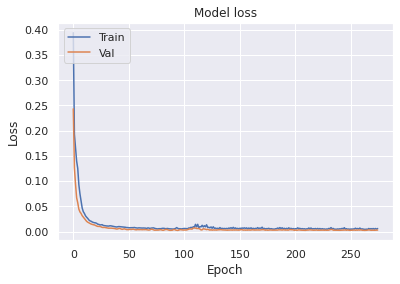

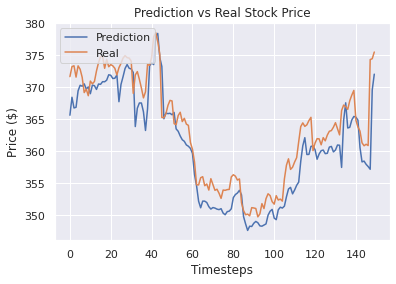

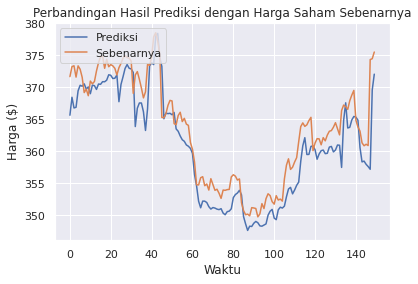

#Train Samples:  951 #Val Samples:  158
Val MAPE:  1.2126762398772397
Val Adjusted MAPE:  0.9065426561744364
Val Accuracy:  0.6783216783216783


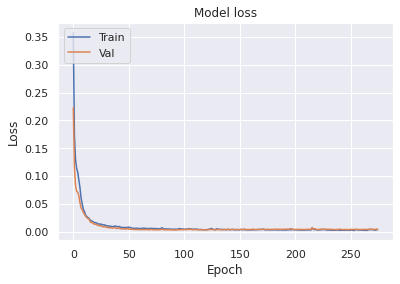

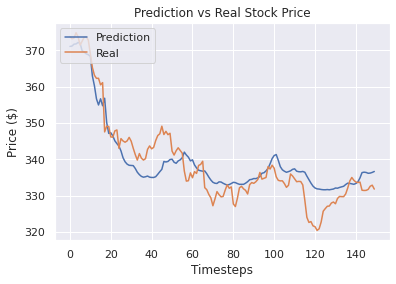

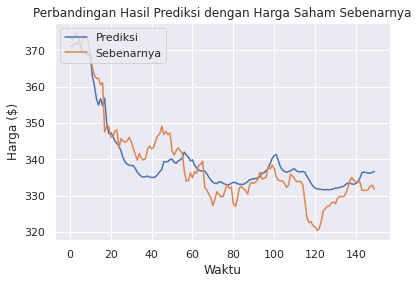

#Train Samples:  1109 #Val Samples:  158
Val MAPE:  1.4072845446080084
Val Adjusted MAPE:  1.0885545957219627
Val Accuracy:  0.8251748251748252


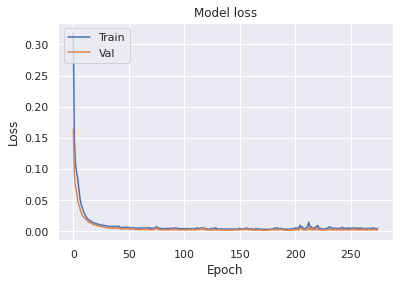

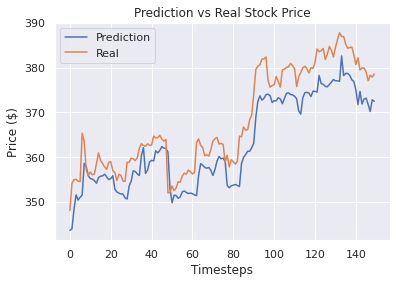

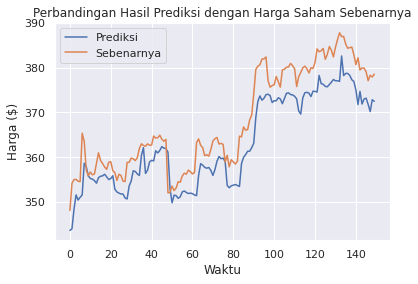

#Train Samples:  1267 #Val Samples:  158
Val MAPE:  0.9147189232737283
Val Adjusted MAPE:  0.627069582902234
Val Accuracy:  0.8251748251748252


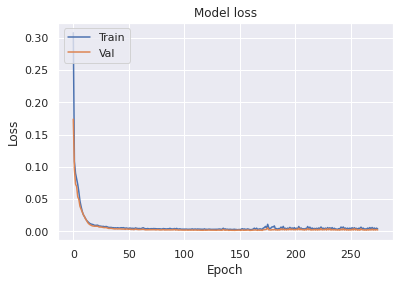

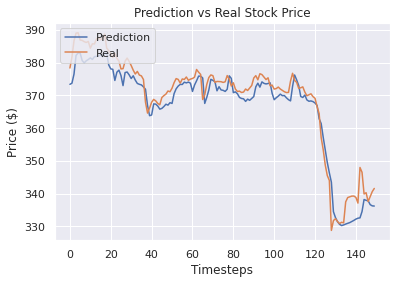

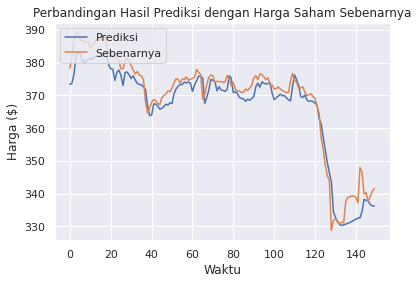

#Train Samples:  1425 #Val Samples:  158
Val MAPE:  1.5925501592311966
Val Adjusted MAPE:  1.1607041133793379
Val Accuracy:  0.6923076923076923


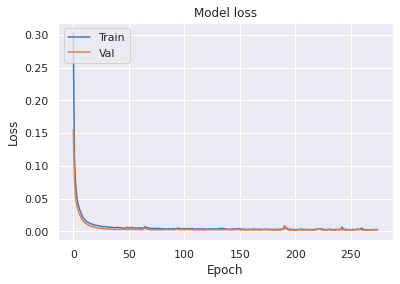

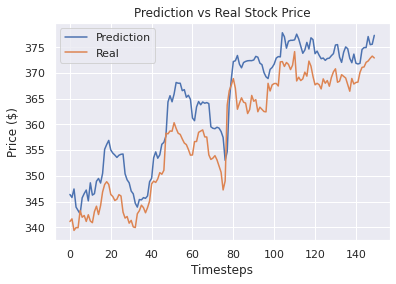

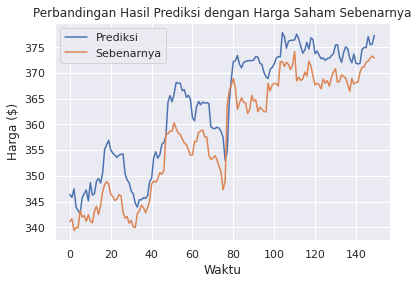

#Train Samples:  1583 #Val Samples:  158
Val MAPE:  0.8507917325985997
Val Adjusted MAPE:  0.6102468003037465
Val Accuracy:  0.7762237762237763


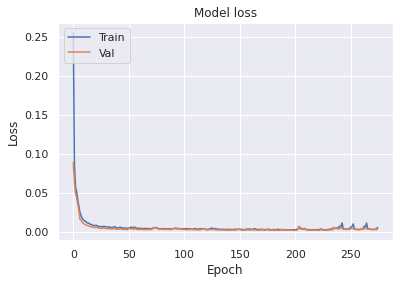

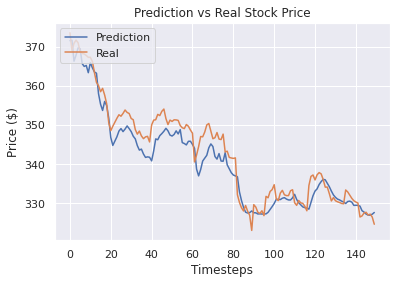

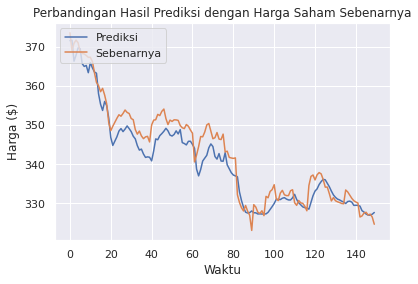

10-Fold Accuracy Test Avg Score: 0.7314685314685315, Std Score: 0.06049658392694314
10-Fold MAPE Test Avg Score: 1.2012491603734463, Std Score: 0.3614002783060934
10-Fold Adjusted MAPE Test Avg Score: 0.8901299140083785, Std Score: 0.28755981585297224
Epochs: 275
LSTM Nodes 1: 256
LSTM Nodes 2: 128
Input Dropout Rate: 0
Hidden Dropout Rate: 0.175
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f80125086d8>



In [0]:
cross_val(df_historical,df_sentiment,TIME_STEPS=7,BATCH_SIZE=25,n_fold=10,
          input_dropout=0,hidden_dropout=0.175,l2_regularizer=0.0025,
          lstm_units_1=256,lstm_units_2=128,
          hidden_units_1=128,hidden_units_2=64,
          optimizer=optimizers.Adam(learning_rate=0.0004),
          epochs=275)

# Plot Model

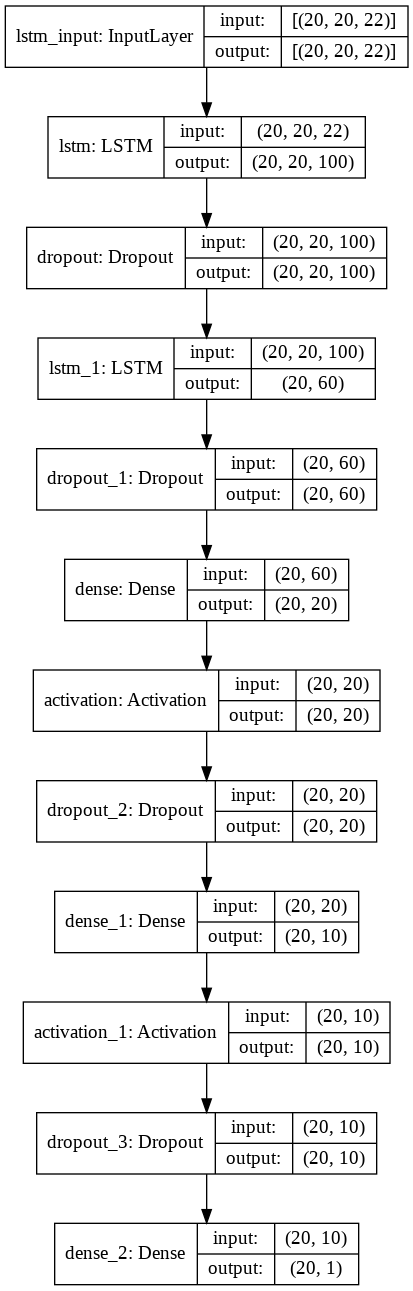

In [0]:
from tensorflow.keras.utils import plot_model
K.clear_session()

TIME_STEPS=20
BATCH_SIZE=20
input_dropout=0
hidden_dropout=0.2
l2_regularizer=0.005
lstm_units_1=100
lstm_units_2=60
hidden_units_1=20
hidden_units_2=10

model=Sequential()
model.add(LSTM(units = lstm_units_1, batch_input_shape=(BATCH_SIZE, TIME_STEPS, 22),  return_sequences=True,dropout=input_dropout, kernel_initializer='random_uniform'))
model.add(Dropout(hidden_dropout))
model.add(LSTM(units = lstm_units_2))
model.add(Dropout(hidden_dropout))
model.add(Dense(hidden_units_1,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
model.add(Activation('relu'))
model.add(Dropout(hidden_dropout))
model.add(Dense(hidden_units_2,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
model.add(Activation('relu'))
model.add(Dropout(hidden_dropout))
model.add(Dense(1))

plot_model(model, show_shapes=True)